In [1]:
# check whether Li+ is increased in electrolyte with replenishment 

In [2]:
import pybamm as pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os; #import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

In [3]:
from pybamm import constants, Parameter

def t_plus_tanh( c_e,c_EC, T  ):
    ratio = c_EC / c_e
    coff = 0.3
    return coff/2 + coff/2 *  pybamm.tanh((ratio-2.7705)*2)


In [4]:
V_max = 4.2;        V_min = 2.5;
Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 0.3 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 1 )  

In [5]:
Model_0 = pybamm.lithium_ion.DFN(     
    options={           
        "solvent diffusion": "EC"     } )
Model_1 = pybamm.lithium_ion.DFN(     
    options={       
        "solvent diffusion": "EC"     } )
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_EMC_FEC_19_1_Landesfeind2019";
#
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':8e-19})

Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] =   "[input]";
Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =   "[input]";
Para_0['EC transference number'] =   "[input]";
Para_0['EC diffusivity [m2.s-1]'] =   "[input]";
Para_0['Electrolyte diffusivity [m2.s-1]'] =   "[input]";

Para_0.search("diffusivity")
gamma_e_ec_Rio = Para_0.evaluate(Model_0.param.gamma_e_ec_Rio)  
print(gamma_e_ec_Rio)

In [6]:

Sim_0    = pybamm.Simulation(
    Model_0, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_0    = Sim_0.solve(
    inputs={
        "EC transference number":-1.4,
        "EC Lithium ion cross diffusivity [m2.s-1]":1.5e-9/1e2,
        "Typical EC Lithium ion cross diffusivity [m2.s-1]":1.5e-9/1e2,
        "EC diffusivity in electrolyte [m2.s-1]":5E-12,
        "Electrolyte diffusivity [m2.s-1]":3E-10,
        });

In [7]:
Para_0.update({'Cation transference number':t_plus_tanh})
Sim_1    = pybamm.Simulation(
    Model_1, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_1    = Sim_1.solve(
    inputs={
        "EC transference number":-1.4,
        "EC Lithium ion cross diffusivity [m2.s-1]":1.5e-9/1e2,
        "Typical EC Lithium ion cross diffusivity [m2.s-1]":1.5e-9/1e2,
        "EC diffusivity in electrolyte [m2.s-1]":5E-12,
        "Electrolyte diffusivity [m2.s-1]":3E-10,
        });

In [8]:
Model_0.variables.search('current density')

Current collector current density
Current collector current density [A.m-2]
Current density variable
Electrode current density
Electrolyte current density
Electrolyte current density [A.m-2]
Exchange current density
Exchange current density [A.m-2]
Inner SEI interfacial current density
Inner SEI interfacial current density [A.m-2]
Inner SEI on cracks interfacial current density
Inner SEI on cracks interfacial current density [A.m-2]
Interfacial current density
Interfacial current density [A.m-2]
Leading-order current collector current density
Lithium plating interfacial current density
Lithium plating interfacial current density [A.m-2]
Negative electrode SEI interfacial current density
Negative electrode SEI interfacial current density [A.m-2]
Negative electrode SEI on cracks interfacial current density
Negative electrode SEI on cracks interfacial current density [A.m-2]
Negative electrode SEI on cracks volumetric interfacial current density
Negative electrode SEI on cracks volumetric

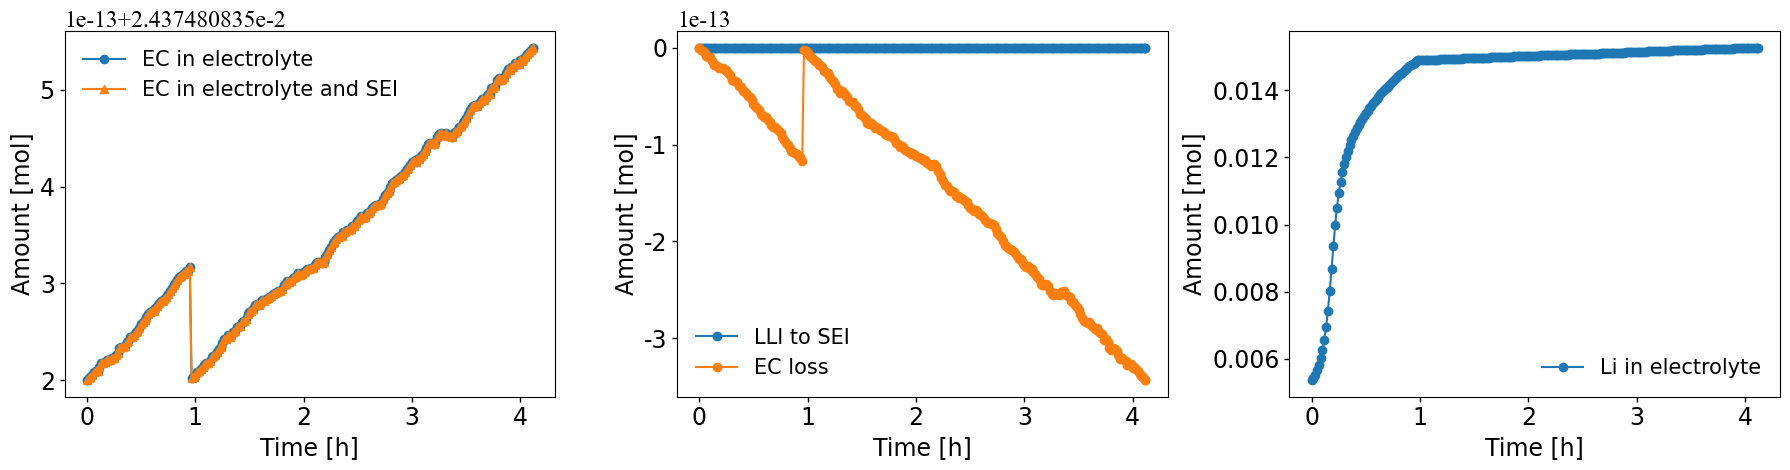

In [9]:
Li_eley = Sol_1["Total lithium in electrolyte [mol]"].entries
EC_eley = Sol_1["Total EC in electrolyte [mol]"].entries
EC_eleySEI = Sol_1["Total EC in electrolyte and SEI [mol]"].entries
t = Sol_1["Time [h]"].entries
LLI_SEI = Sol_1["Loss of lithium to SEI [mol]"].entries


fig, axs = plt.subplots(1,3, figsize=(18,4.8),tight_layout=True)
axs[0].plot(t, EC_eley,'-o',label="EC in electrolyte")
axs[0].plot(t, EC_eleySEI,'-^',label="EC in electrolyte and SEI"  )
axs[1].plot(t, LLI_SEI,'-o',label="LLI to SEI" )
axs[1].plot(t, EC_eley[0]-EC_eley,'-o',label="EC loss" )
axs[2].plot(t, Li_eley,'-o',label="Li in electrolyte" )
for i in range(0,3):
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
    
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    


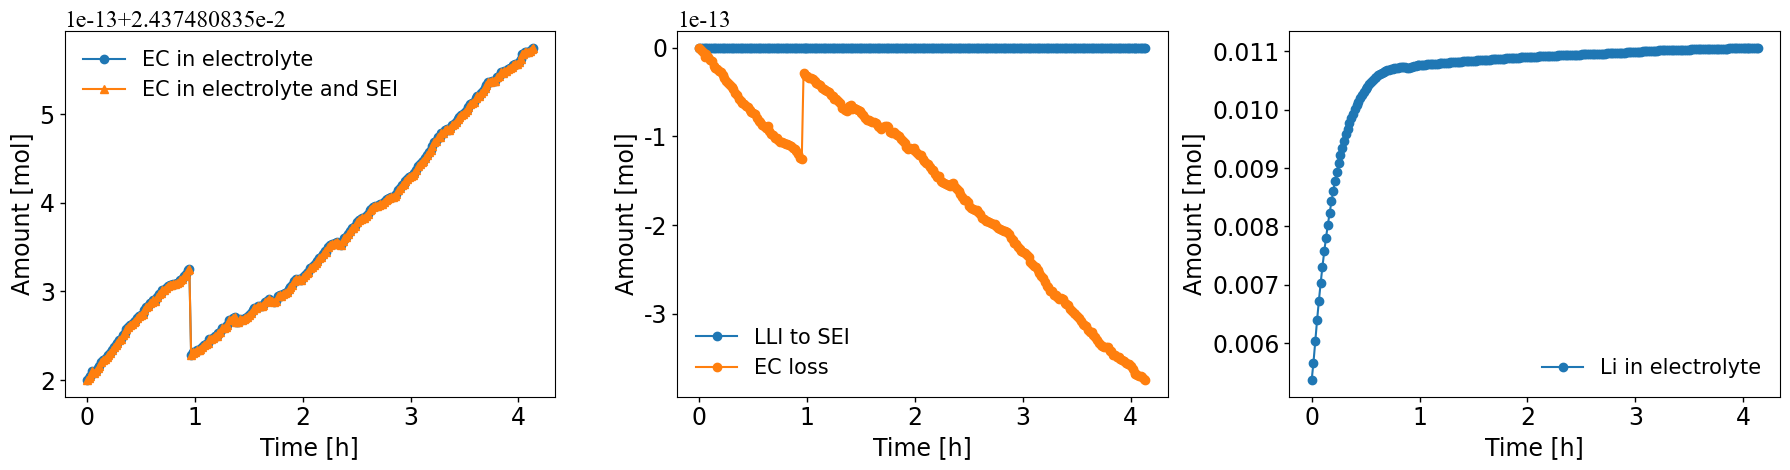

In [10]:
Li_eley = Sol_0["Total lithium in electrolyte [mol]"].entries
EC_eley = Sol_0["Total EC in electrolyte [mol]"].entries
EC_eleySEI = Sol_0["Total EC in electrolyte and SEI [mol]"].entries
t = Sol_0["Time [h]"].entries
LLI_SEI = Sol_0["Loss of lithium to SEI [mol]"].entries


fig, axs = plt.subplots(1,3, figsize=(18,4.8),tight_layout=True)
axs[0].plot(t, EC_eley,'-o',label="EC in electrolyte")
axs[0].plot(t, EC_eleySEI,'-^',label="EC in electrolyte and SEI"  )
axs[1].plot(t, LLI_SEI,'-o',label="LLI to SEI" )
axs[1].plot(t, EC_eley[0]-EC_eley,'-o',label="EC loss" )
axs[2].plot(t, Li_eley,'-o',label="Li in electrolyte" )
for i in range(0,3):
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
    
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    


In [11]:
label = ["default t_0+","tanh t_0+",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    #"Total EC in electrolyte [mol]",
    "Total EC in electrolyte and SEI [mol]",
    "Total lithium in electrolyte [mol]",
    #"Loss of capacity to SEI [A.h]",
    "Loss of lithium to SEI [mol]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=4.133532455876685, step=0.041335324558766845…

In [12]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "Negative electrode SEI interfacial current density [A.m-2]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=4.133532455876685, step=0.041335324558766845…

In [13]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    "Total lithium in electrolyte [mol]",   
    "Total lithium lost from electrolyte [mol]",
    "Total lithium [mol]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();


interactive(children=(FloatSlider(value=0.0, description='t', max=4.133532455876685, step=0.041335324558766845…